In [414]:
import pandas as pd
from collections import Counter
import nltk
import os
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import numpy as np
import json

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [415]:
file_data = json.load(open("../data/ServiceAccountsKey.json"))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")


In [62]:
metadata_table_long = pd.read_csv("../data/metadata_table_long.csv")


In [151]:
len(metadata_table_long)

1054

In [155]:
metadata_table_long.drop_duplicates(subset="id", keep="first", inplace=True)
len(metadata_table_long)

975

In [156]:
metadata_table_long.head(5)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,Written by,Library and Signature,ids,id,date_min,date_max,filename,file_year,sents_n,words_n
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),...,IT,NaN,[607720],607720,1672.0,1672.0,"Pardies,_Ignace_Gaston_-_A_Latin_Letter_contai...",1672.0,52.0,1145.0
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",...,MK,NaN,[605919],605919,1723.0,1723.0,"Scheuchzer,_Johann_Jakob_-_ΟΥΡΕΣΙΦΟΙΤΗΣ_(Oures...",1723.0,20640.0,191776.0
3,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,MK,NaN,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0,3297.0,38011.0
5,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,...,IT,NaN,[900767],900767,1606.0,1606.0,"Owen,_Johan_-_Epigrammatum_libri_tres__Amberg_...",1608.0,NaN,NaN
6,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,MK,NaN,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0,6137.0,66744.0


In [157]:
id = metadata_table_long["id"][1]

In [158]:
with open("../data/large_data/sents_lemmata/{}.txt".format(str(id)), "r") as f:
    sents_lemmata = [sent.strip().split() for sent in f.readlines()]

In [159]:
lemmata = [l for s in sents_lemmata for l in s]
lemmata[:20]

['ioh',
 'iac',
 'scheuchzeri',
 'itinera',
 'alpina',
 'plurimus',
 'tabula',
 'aeneus',
 'illustro',
 'lugud',
 'bat',
 'sumptibus',
 'petrus',
 'vander',
 'aa.',
 'ουρεσιφοιτης',
 'helveticus',
 'sive',
 'itinera',
 'per']

In [160]:
word_counts = dict(nltk.FreqDist(lemmata).most_common())

In [161]:
files_ready = os.listdir("../data/large_data/sents_lemmata")
len(files_ready)

1007

In [162]:
%%time
files_ready = os.listdir("../data/large_data/sents_lemmata")
vocab_counter = Counter()
overview_dict = {}
for fn in files_ready:
    with open("../data/large_data/sents_lemmata/" + fn, "r") as f:
        sents_lemmata = [sent.strip().split() for sent in f.readlines()]
    sents_n = len(sents_lemmata)
    lemmata = [l for s in sents_lemmata for l in s]
    words_n = len(lemmata)
    overview_dict[fn.partition(".")[0]] = {"sents_n" : sents_n, "words_n" : words_n} 
    word_counts = dict(nltk.FreqDist(lemmata).most_common())
    vocab_counter.update(word_counts)

CPU times: user 1min 10s, sys: 1.18 s, total: 1min 11s
Wall time: 1min 13s


In [163]:
sum(vocab_counter.values())

108184367

In [164]:
def get_sents_n(id):
    try:
        return overview_dict[str(id)]["sents_n"]
    except:
        return None
metadata_table_long["sents_n"] = metadata_table_long["id"].apply(get_sents_n)

def get_words_n(id):
    try:
        return overview_dict[str(id)]["words_n"]
    except:
        return None
metadata_table_long["words_n"] = metadata_table_long["id"].apply(get_words_n)
metadata_table_long.head(5)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,Written by,Library and Signature,ids,id,date_min,date_max,filename,file_year,sents_n,words_n
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),...,IT,NaN,[607720],607720,1672.0,1672.0,"Pardies,_Ignace_Gaston_-_A_Latin_Letter_contai...",1672.0,52,1145
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",...,MK,NaN,[605919],605919,1723.0,1723.0,"Scheuchzer,_Johann_Jakob_-_ΟΥΡΕΣΙΦΟΙΤΗΣ_(Oures...",1723.0,20640,191776
3,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,MK,NaN,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0,3297,38011
5,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,...,IT,NaN,[900767],900767,1606.0,1606.0,"Owen,_Johan_-_Epigrammatum_libri_tres__Amberg_...",1608.0,3007,19149
6,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,MK,NaN,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0,6137,66744


In [167]:
metadata_table_long["words_n"].sum()

106533965

In [172]:
metadata_table_long.groupby("Discipline/Content").sum()[["sents_n", "words_n"]].sort_values("words_n", ascending=False)

,sents_n,words_n
Discipline/Content,,
Medicine,3325536,21797337
Biology,1469662,12903768
Astronomy/Astrology/Cosmography,860837,11435941
Mathematics,577068,6983620
"Biology, Medicine",639458,5733350
...,...,...
"Physics, Biology, Medicine, Other (see description)",394,6910
"Mathematics, Astronomy/Astrology/Cosmography, Meteorology/Earth sciences, Alchemy/Chemistry, Biology, Medicine, Other (see description)",518,6685
"Mathematics, Physics, Astronomy/Astrology/Cosmography, Meteorology/Earth sciences, Medicine, Other (see description)",448,5092


In [177]:
def get_disciplines_list(string):
    try:
        disciplines_list = string.split(", ")
    except:
        disciplines_list = []
    return disciplines_list
metadata_table_long["disciplines_list"] = metadata_table_long["Discipline/Content"].apply(get_disciplines_list)

In [181]:
nltk.FreqDist([el for ls in metadata_table_long["disciplines_list"] for el in ls]).most_common(50)

[('Medicine', 359),
 ('Biology', 271),
 ('Astronomy/Astrology/Cosmography', 266),
 ('Meteorology/Earth sciences', 207),
 ('Mathematics', 205),
 ('Physics', 180),
 ('Geography/Cartography', 133),
 ('Other (see description)', 120),
 ('Alchemy/Chemistry', 103)]

In [453]:
set([el for l in metadata_table_long["disciplines_list"].tolist() for el in l])

{'Alchemy/Chemistry',
 'Astronomy/Astrology/Cosmography',
 'Biology',
 'Geography/Cartography',
 'Mathematics',
 'Medicine',
 'Meteorology/Earth sciences',
 'Other (see description)',
 'Physics'}

In [ ]:
natural_history = []
natural

In [187]:
ls = ['Mathematics',
      'Physics',
      'Geography/Cartography',
      'Meteorology/Earth sciences',
      'Alchemy/Chemistry',
      'Biology',
      'Medicine']

In [182]:
life_sciences = ['Medicine', 'Biology']
physical_sciences = ['Astronomy/Astrology/Cosmography', 'Meteorology/Earth sciences', 'Mathematics', 'Physics', 'Geography/Cartography', 'Alchemy/Chemistry']

In [190]:
bool(set(ls).intersection(set(life_sciences)))

True

In [216]:
def get_science_class(ls):
    if bool(set(ls).intersection(set(life_sciences))):
        if bool(set(ls).intersection(set(physical_sciences))):
            science_class = "mixture"
        else:
            science_class = "life_sciences"
    else:
        science_class = "exact_sciences"
    return science_class

In [217]:
ls = ['Mathematics',
      'Physics',
      'Geography/Cartography',
      'Meteorology/Earth sciences',
      'Alchemy/Chemistry',
      'Biology',
      'Medicine']

In [218]:
metadata_table_long["science_class"] = metadata_table_long["disciplines_list"].apply(get_science_class)

In [219]:
metadata_table_long.head(5)

,Author,Full title,In,Year,Place,Publisher/Printer,Era,Form/Genre,Discipline/Content,Original,...,ids,id,date_min,date_max,filename,file_year,sents_n,words_n,disciplines_list,science_class
0,"Pardies, Ignace Gaston",A Latin Letter written to the Publisher April ...,Philosophical Transactions of the Royal Societ...,1672,London,Martyn,17th century,"Letter, Review",Physics,A Latin Letter(JSTOR),...,[607720],607720,1672.0,1672.0,"Pardies,_Ignace_Gaston_-_A_Latin_Letter_contai...",1672.0,52,1145,[Physics],exact_sciences
1,"Scheuchzer, Johann Jakob","Acarnania sive Relatio eorum, quae hactenus el...","ΟΥΡΕΣΙΦΟΙΤΗΣ (Ouresiphoites) Helveticus, 609–35",1723,Leiden,"van der Aa, Pieter",18th century,"Biography, Bibliography","Mathematics, Physics, Geography/Cartography, M...","Acarnania (1st edition), inMiscellanea Lipsien...",...,[605919],605919,1723.0,1723.0,"Scheuchzer,_Johann_Jakob_-_ΟΥΡΕΣΙΦΟΙΤΗΣ_(Oures...",1723.0,20640,191776,"[Mathematics, Physics, Geography/Cartography, ...",mixture
3,"Addison, Joseph",Ad insignissimum virum dominum Thomam Burnettu...,"Examen poeticum duplex, sive, Musarum anglican...",1698,London,Richard Wellington I.,17th century,Panegyric poem,Meteorology/Earth sciences,Ad Burnettum sacrae theoriae telluris auctorem...,...,[769230],769230,1698.0,1698.0,Examen_poeticum_duplex__London_1698_pdf.txt,1698.0,3297,38011,[Meteorology/Earth sciences],exact_sciences
5,"Owen, John",Ad Dominum Gilbertum,Epigrammatum libri tres. Auctore Ioanne Owen B...,1606,London,"Windet, John, Waterson, Simon",17th century,Other (see description),Astronomy/Astrology/Cosmography,3rd edition (Amberg 1608)(Google Books)Digital...,...,[900767],900767,1606.0,1606.0,"Owen,_Johan_-_Epigrammatum_libri_tres__Amberg_...",1608.0,3007,19149,[Astronomy/Astrology/Cosmography],exact_sciences
6,"Acidalius, Valens","Ad Iordanum Brunum Nolanum, Italum","Poematum Iani Lernutii, Iani Gulielmi, Valenti...",1603,"Liegnitz, Wrocław","Albert, David",17th century,Panegyric poem,Astronomy/Astrology/Cosmography,Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...,...,[801745],801745,1603.0,1603.0,Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...,1603.0,6137,66744,[Astronomy/Astrology/Cosmography],exact_sciences


Text(0, 0.5, 'words n')

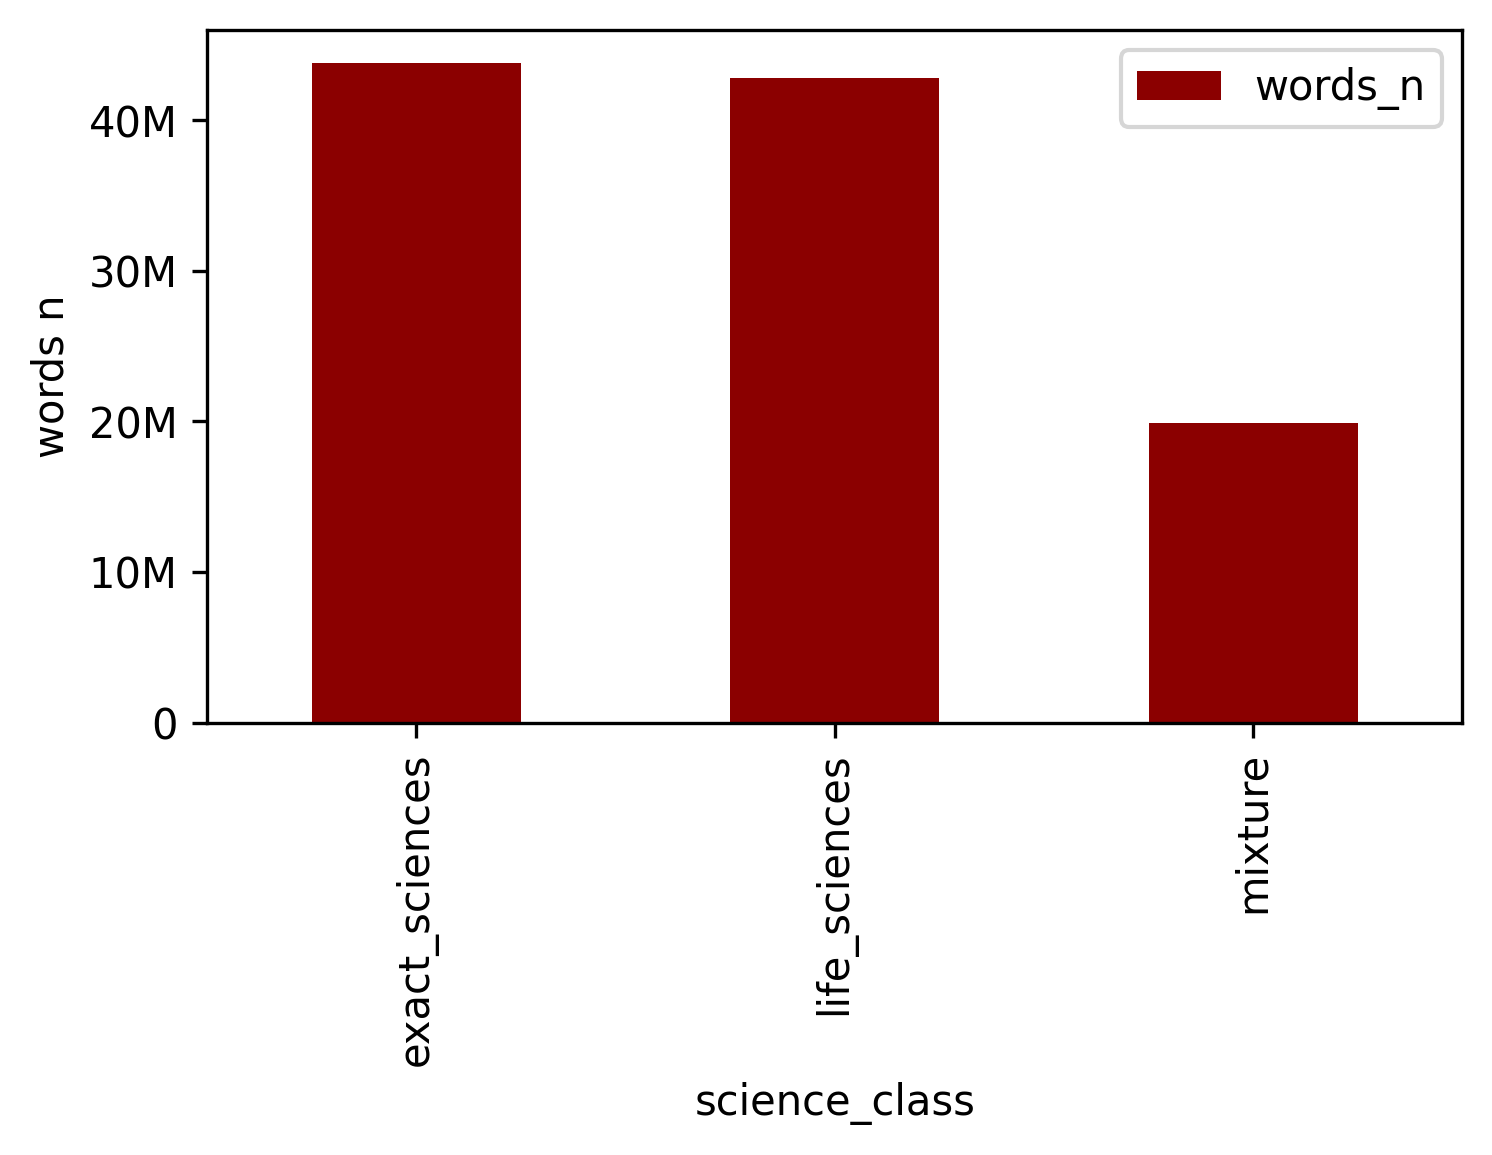

In [257]:
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300)
metadata_table_long.groupby("science_class").sum()[["words_n"]].plot.bar(color="darkred", ax=ax)
ax.set_yticks(range(0,50000000, 10000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(10,50,10)])
ax.set_ylabel("words n")

Text(0, 0.5, 'words n')

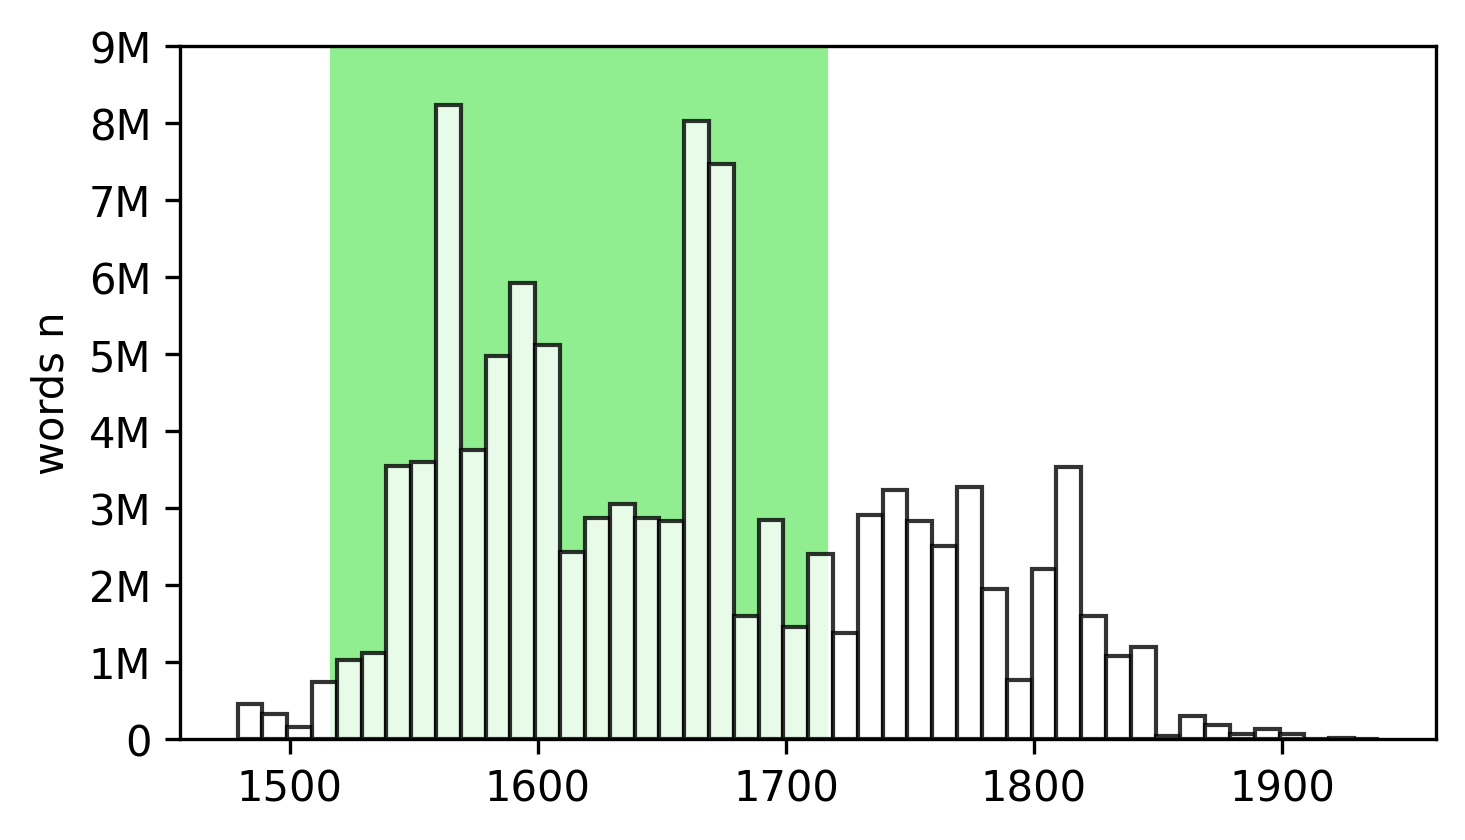

In [279]:
data = []
for start in range(1470,1930,10):
    end = start + 9
    subset = metadata_table_long[metadata_table_long["file_year"].between(start, end)]
    words_n = subset["words_n"].sum()
    data.append((start, end, words_n))

fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300)

ax.axvspan(1517, 1716, color="lightgreen")
ax.bar(x=[el[1]+5 for el in data], height=[el[2] for el in data], align='center', color="white", edgecolor="black", alpha=0.8, width=10)
ax.set_yticks(range(0,10000000, 1000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(1,10)])
ax.set_ylabel("words n")

Text(0, 0.5, 'words n')

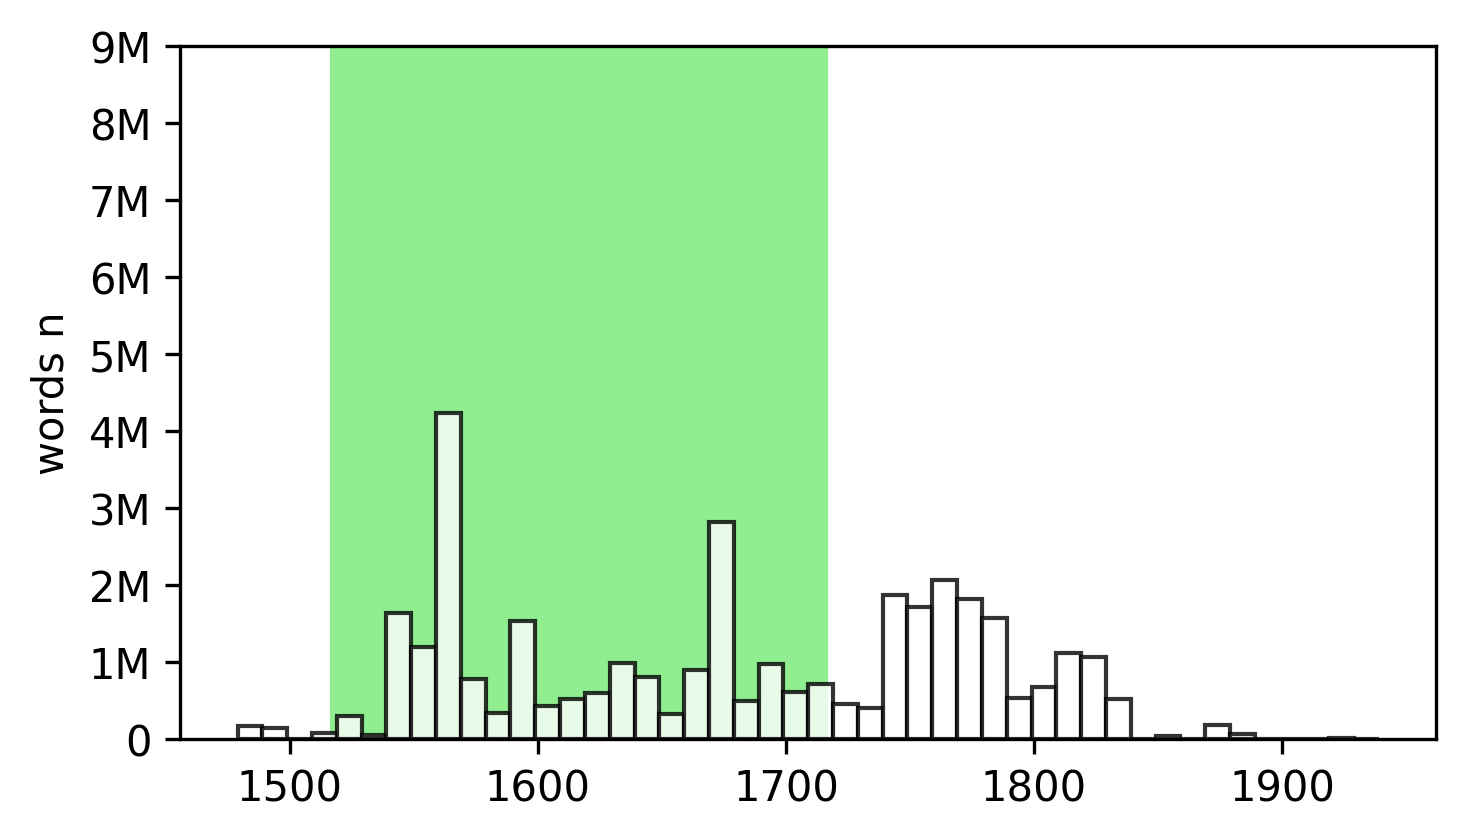

In [454]:
data = []
for start in range(1470,1930,10):
    end = start + 9
    subset = metadata_table_long[metadata_table_long["disciplines_list"].apply(lambda x: "Biology" in x)]
    subset = subset[subset["file_year"].between(start, end)]
    words_n = subset["words_n"].sum()
    data.append((start, end, words_n))

fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300)

ax.axvspan(1517, 1716, color="lightgreen")
ax.bar(x=[el[1]+5 for el in data], height=[el[2] for el in data], align='center', color="white", edgecolor="black", alpha=0.8, width=10)
ax.set_yticks(range(0,10000000, 1000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(1,10)])
ax.set_ylabel("words n")

Text(0, 0.5, 'words n')

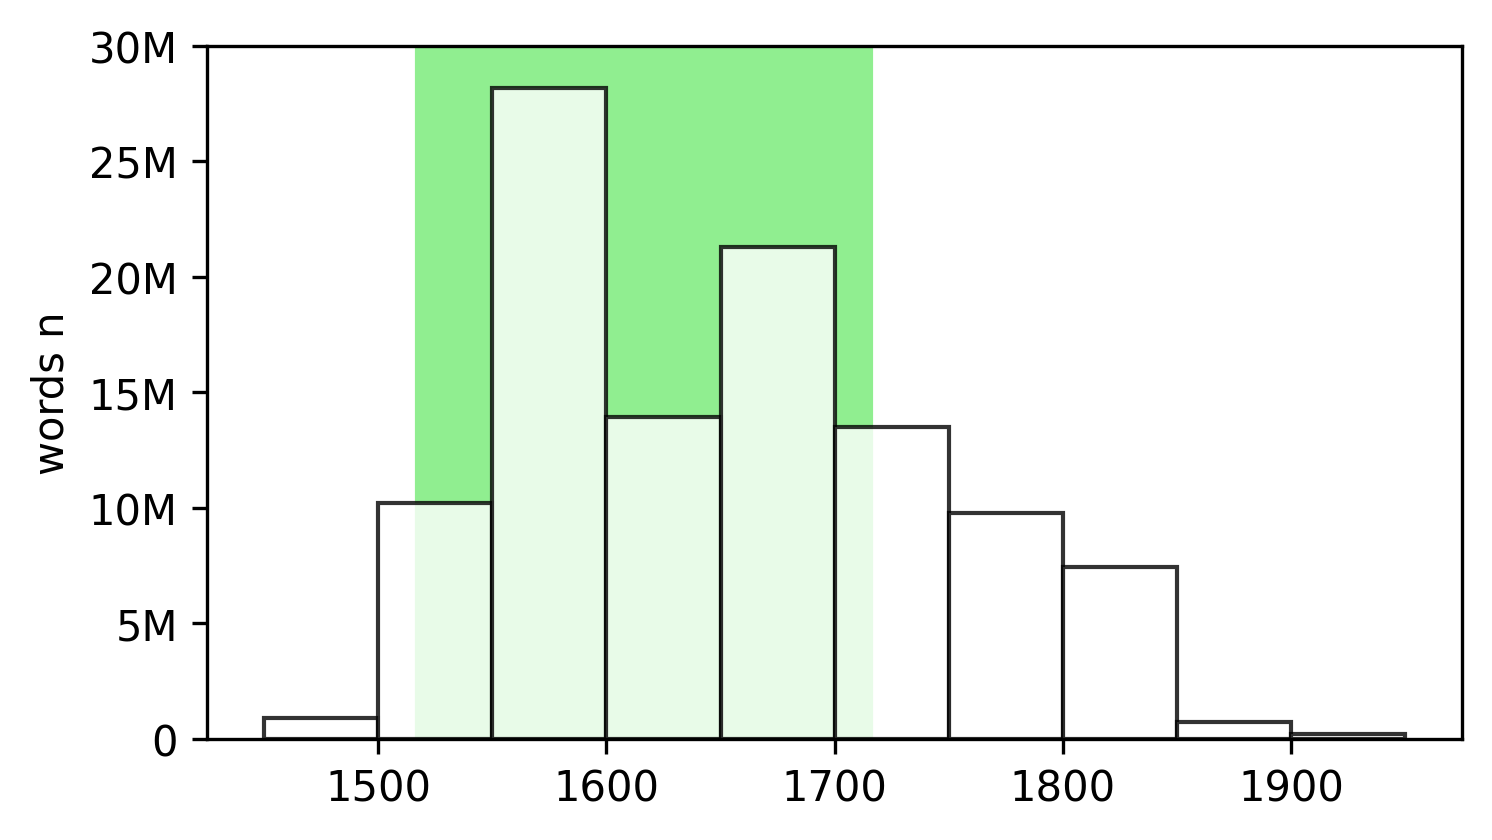

In [281]:
data = []
for start in range(1451,1951,50):
    end = start + 49
    subset = metadata_table_long[metadata_table_long["file_year"].between(start, end)]
    words_n = subset["words_n"].sum()
    data.append((start, end, words_n))

fig, ax = plt.subplots(figsize=(5.4, 3), dpi=300)

ax.axvspan(1517, 1716, color="lightgreen")
ax.bar(x=[el[0]+24 for el in data], height=[el[2] for el in data], align='center', color="white", edgecolor="black", alpha=0.8, width=50)
ax.set_yticks(range(0,35000000, 5000000))
ax.set_yticklabels(["0"] + [str(el)+"M" for el in range(5,35,5)])
ax.set_ylabel("words n")

In [416]:
set_with_dataframe(noscemus_gs.add_worksheet("metadata_table_long_v3", 1,1), metadata_table_long)

# Temporal analysis of coocuccerences - development & testing

In [444]:
%%time
target = "harmonia" # choose your target word, ie. the word which's context you want to investigate
start = 1551 # choose the start your of the period under 
end = start + 49 # end of the period
ids = metadata_table_long[metadata_table_long["file_year"].between(start, end)]["id"] # use the metadata table to extract IDs of all works falling into this period
vocab_counter = Counter() # initiate an empty counter of words - we will feed it iterarively on the go by all words we meet
target_sents = [] # initiate an empty list of sentences containing the target word
for id in ids: # for each work ID from our subset of IDs
    # based on the ID, open the file containing the lemmatized sentences and load its content as a list of lists
    with open("../data/large_data/sents_lemmata/{}.txt".format(str(id)), "r") as f:
        sents_lemmata = [sent.strip().split() for sent in f.readlines()]
    # based on the ID, open the file containing POS tags of the sentences and load its content as a list of lists
    # (this object should have the same structure as the previous one, what allows us to do a sort of filtering based on selected POS tags
    with open("../data/large_data/sents_pos/{}.txt".format(str(id)), "r") as f:
        sents_pos = [sent.strip().split() for sent in f.readlines()]
    sents_n = len(sents_lemmata) # count the number of sentences within the document
    lemmata = [l for s in sents_lemmata for l in s] # represent the whole work as one continuous list of words
    word_counts = dict(nltk.FreqDist(lemmata).most_common()) # count all words within the lemmata list
    vocab_counter.update(word_counts) # update the counter by these words
    sents_lemmata_filtered = [] # initiate a new empty list for sentence lemmata filtered by POS tags 
    for n in range(len(sents_lemmata)):
        pos_indices = [t[0] for t in enumerate(sents_pos[n]) if t[1] in ["PROPN", "NOUN","VERB", "ADJ"]] # PROPN
        sent = sents_lemmata[n]
        try:
            sent_filtered = [sent[i] for i in pos_indices]
        except:
            sent_filtered = []
        #sent_filtered = [el for el in sent_filtered if len(el) > 2]
        sents_lemmata_filtered.append(sent_filtered)
    target_sents_local = [sent for sent in sents_lemmata_filtered if target in sent]
    target_sents.extend(target_sents_local)
target_coocs_counts = dict(nltk.FreqDist([t for s in target_sents for t in s]).most_common())
target_coocs_n = sum(target_coocs_counts.values())
target_coocs_freqs = dict([(tup[0], tup[1] / target_coocs_n) for tup in target_coocs_counts.items()])
words_n = sum(vocab_counter.values())
words_freqs = dict([(tup[0], tup[1] / words_n) for tup in vocab_counter.items()])

CPU times: user 33.5 s, sys: 953 ms, total: 34.5 s
Wall time: 37.8 s


In [450]:
len(target_sents)

584

In [446]:
print(target_sents[:5])

[['temperatura', 'harmonia', 'comparo'], ['harmonia'], ['harmonia', 'foramen', 'figo', 'additamentum', 'uicno', 'uicus', 'simplex', 'linea', 'iungo'], ['facio', 'possum', 'species', 'sutura', 'gomphosum', 'harmonia', 'cap'], ['libei', 'phosum', 'harmonia', 'articulum', 'species', 'synarthrosins', 'symphysis', 'genus', 'articulus', 'contrarius', 'tino']]


In [451]:
target_coocs_counts

{'harmonia': 617,
 'omnis': 131,
 'corpus': 90,
 'numerus': 66,
 'anima': 63,
 'dico': 62,
 'facio': 58,
 'motus': 56,
 'pars': 51,
 'ratio': 50,
 'totus': 50,
 'suus': 49,
 'habeo': 48,
 'res': 47,
 'primus': 47,
 'coelestis': 45,
 'possum': 44,
 'uerò': 44,
 'proportio': 41,
 'ordo': 37,
 'homo': 36,
 'natura': 34,
 'os': 34,
 'animus': 33,
 'uideo': 32,
 'deus': 31,
 'diuinus': 30,
 'causa': 29,
 'quàm': 29,
 'perfectus': 29,
 'nihil': 26,
 'musicus': 26,
 'formo': 25,
 'modus': 25,
 'sensus': 25,
 'uox': 25,
 'mundus': 23,
 'mens': 23,
 'efficio': 23,
 'unus': 22,
 'qualitas': 22,
 'uniuersus': 22,
 'genus': 21,
 'constituo': 21,
 'uis': 21,
 'sonus': 21,
 'singulus': 20,
 'proprius': 20,
 'concentus': 20,
 'figura': 20,
 'consto': 19,
 'spiritus': 19,
 'diuersus': 19,
 'cantus': 19,
 'species': 18,
 'uirtus': 18,
 'noster': 18,
 'multus': 18,
 'coelum': 18,
 'locus': 17,
 'tempus': 17,
 'superior': 17,
 'nullus': 17,
 'uita': 17,
 'simplex': 16,
 'principium': 16,
 'forma': 16,
 '

In [447]:
target_coocs_freqs_weighted = {}
for key in target_coocs_freqs.keys():
    target_coocs_freqs_weighted[key] = np.log((target_coocs_freqs[key])**2 / (words_freqs[key] * words_freqs[target]))
for tup in sorted(target_coocs_freqs_weighted.items(), key=lambda x:x[1], reverse=True)[:20]:
    print(tup + (vocab_counter[tup[0]], target_coocs_counts[tup[0]]))

('harmonia', 16.160755753946077, 629, 617)
('gomphosum', 10.56607917905207, 4, 3)
('porismatum', 10.448296143395686, 8, 4)
('diapasson', 10.448296143395686, 2, 2)
('notiora', 10.448296143395686, 2, 2)
('concinentia', 10.448296143395686, 2, 2)
('representando', 10.448296143395686, 2, 2)
('phonga', 10.448296143395686, 2, 2)
('concentus', 10.423603530805314, 205, 20)
('exaedri', 10.26597458660173, 15, 5)
('harf', 10.042831035287522, 3, 2)
('strepis', 10.042831035287522, 3, 2)
('rythmo', 10.006463391116647, 7, 3)
('tetraedri', 9.75514896283574, 36, 6)
('blas', 9.75514896283574, 4, 2)
('videbat', 9.75514896283574, 4, 2)
('harmonie', 9.75514896283574, 4, 2)
('composia', 9.75514896283574, 4, 2)
('suturas', 9.75514896283574, 4, 2)
('gomphrosum', 9.75514896283574, 1, 1)


In [ ]:
ids = metadata_table_long[metadata_table_long["file_year"].between(start, end)]["id"] # use the metadata table to extract IDs of all works falling into this period

def get_target_mi(ids, target):
    vocab_counter = Counter() # initiate an empty counter of words - we will feed it iterarively on the go by all words we meet
    target_sents = [] # initiate an empty list of sentences containing the target word
    for id in ids: # for each work ID from our subset of IDs
        # based on the ID, open the file containing the lemmatized sentences and load its content as a list of lists
        with open("../data/large_data/sents_lemmata/{}.txt".format(str(id)), "r") as f:
            sents_lemmata = [sent.strip().split() for sent in f.readlines()]
        # based on the ID, open the file containing POS tags of the sentences and load its content as a list of lists
        # (this object should have the same structure as the previous one, what allows us to do a sort of filtering based on selected POS tags
        with open("../data/large_data/sents_pos/{}.txt".format(str(id)), "r") as f:
            sents_pos = [sent.strip().split() for sent in f.readlines()]
        sents_n = len(sents_lemmata) # count the number of sentences within the document
        lemmata = [l for s in sents_lemmata for l in s] # represent the whole work as one continuous list of words
        word_counts = dict(nltk.FreqDist(lemmata).most_common()) # count all words within the lemmata list
        vocab_counter.update(word_counts) # update the counter by these words
        sents_lemmata_filtered = [] # initiate a new empty list for sentence lemmata filtered by POS tags 
        for n in range(len(sents_lemmata)):
            pos_indices = [t[0] for t in enumerate(sents_pos[n]) if t[1] in ["PROPN", "NOUN","VERB", "ADJ"]] # PROPN
            sent = sents_lemmata[n]
            try:
                sent_filtered = [sent[i] for i in pos_indices]
            except:
                sent_filtered = []
            #sent_filtered = [el for el in sent_filtered if len(el) > 2]
            sents_lemmata_filtered.append(sent_filtered)
        target_sents_local = [sent for sent in sents_lemmata_filtered if target in sent]
        target_sents.extend(target_sents_local)
    target_coocs_counts = dict(nltk.FreqDist([t for s in target_sents for t in s]).most_common())
    target_coocs_n = sum(target_coocs_counts.values())
    target_coocs_freqs = dict([(tup[0], tup[1] / target_coocs_n) for tup in target_coocs_counts.items()])
    words_n = sum(vocab_counter.values())
    words_freqs = dict([(tup[0], tup[1] / words_n) for tup in vocab_counter.items()])

In [ ]:
%%time
for id in ids:
    with open("../data/large_data/sents_lemmata/" + fn, "r") as f:
        sents_lemmata = [sent.strip().split() for sent in f.readlines()]
    sents_n = len(sents_lemmata)
    lemmata = [l for s in sents_lemmata for l in s]
    words_n = len(lemmata)
    overview_dict[fn.partition(".")[0]] = {"sents_n" : sents_n, "words_n" : words_n}
    word_counts = dict(nltk.FreqDist(lemmata).most_common())
    vocab_counter.update(word_counts)

In [136]:
N = 50
vocab_thres5 = [tup for tup in zip(vocab_counter.keys(), vocab_counter.values()) if tup[1] >= N]
sum([tup[1] for tup in vocab_thres5])

76446369

In [137]:
len(vocab_thres5)

67389

In [138]:
lasla = KeyedVectors.load_word2vec_format("../data/large_data/allLASLA-lemmi-fast-100-SKIP-win5-min5.vec")
operamayora = KeyedVectors.load_word2vec_format("../data/large_data/opera-maiora-lemmas_skip_100.vec")


In [139]:
lasla_vocab = lasla.index_to_key
len(lasla_vocab)

11327

In [140]:
noscemus_vocab_aboveN = [el[0] for el in vocab_thres5]

In [142]:
lasla_noscemus_overlap = list(set(lasla_vocab) & set(noscemus_vocab_aboveN)) 

In [143]:
len(lasla_noscemus_overlap)

8728

In [125]:
lasla_noscemus_overlap

['mutio',
 'appareo',
 'insero',
 'quemadmodum',
 'phoenice',
 'deprimo',
 'promissum',
 'nihilum',
 'sto',
 'melleus',
 'decus',
 'temperatus',
 'demens',
 'nuntio',
 'uiaticum',
 'procerus',
 'patrona',
 'grauis',
 'saturo',
 'impono',
 'sponsio',
 'memmius',
 'lente',
 'communitas',
 'absis',
 'serenitas',
 'abeo',
 'leuiter',
 'catillus',
 'siligineus',
 'debilitas',
 'significatio',
 'euomo',
 'persisto',
 'minutus',
 'prandium',
 'arctus',
 'cos',
 'delia',
 'piger',
 'amburo',
 'status',
 'irrigo',
 'bithynus',
 'uiduus',
 'pernosco',
 'religio',
 'destillo',
 'centuria',
 'insidiator',
 'agna',
 'corinthius',
 'qualiscumque',
 'paulisper',
 'austerus',
 'huc',
 'exedo',
 'cadus',
 'caelicola',
 'lego',
 'undecimus',
 'cohors',
 'niger',
 'effusus',
 'famulus',
 'alica',
 'ubi',
 'saturnus',
 'pusillum',
 'praetexo',
 'niualis',
 'nympha',
 'clientela',
 'annalis',
 'transeo',
 'arundo',
 'lautitia',
 'destinatus',
 'rescindo',
 'themistocles',
 'ara',
 'area',
 'immaturus',
 'p